The text data is already pretty clean, so not much preparation is required. Without getting too
much into the details, we will prepare the data using the following method:
Split tokens on white space.

- Remove all punctuation from words.
- Remove all words that are not purely comprised of alphabetical characters.
- Remove all words that are known stop words.
- Remove all words that have a length ≤ 1 character.

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import re
from os import listdir
from collections import Counter

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)
    
# load all docs in a directory
def process_docs(directory, vocab):
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # add doc to vocab
        add_doc_to_vocab(path, vocab)
        
# save list to file
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()
        
# define vocab
vocab = Counter()
# add all docs to vocab
process_docs('txt_sentoken/pos', vocab)
process_docs('txt_sentoken/neg', vocab)
# print the size of the vocab
print(len(vocab))
# keep tokens with a min occurrence
min_occurane = 2
tokens = [k for k,c in vocab.items() if c >= min_occurane]
print(len(tokens))
# save tokens to a vocabulary file
save_list(tokens, 'vocab.txt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vivek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


44276
25767


We are now ready to look at extracting features from the reviews ready for modeling.

In [2]:
import string
import re
from os import listdir
from nltk.corpus import stopwords

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab):
    lines = list()
        # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines
    
# load and clean a dataset
def load_clean_dataset(vocab):
    # load documents
    neg = process_docs('txt_sentoken/neg', vocab)
    pos = process_docs('txt_sentoken/pos', vocab)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
# load all training reviews
docs, labels = load_clean_dataset(vocab)
# summarize what we have
print(len(docs), len(labels))

1800 1800


In [3]:
import string
import re
from os import listdir
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer

#load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_train):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

# load and clean a dataset
def load_clean_dataset(vocab, is_train):
    # load documents
    neg = process_docs('txt_sentoken/neg', vocab, is_train)
    pos = process_docs('txt_sentoken/pos', vocab, is_train)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(Xtrain.shape, Xtest.shape)

Using TensorFlow backend.


(1800, 25768) (200, 25768)


In [4]:
import string
import re
from os import listdir
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

#load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_train):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

# load and clean a dataset
def load_clean_dataset(vocab, is_train):
    # load documents
    neg = process_docs('txt_sentoken/neg', vocab, is_train)
    pos = process_docs('txt_sentoken/pos', vocab, is_train)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    return model

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
# define the model
n_words = Xtest.shape[1]
model = define_model(n_words)
# fit network
model.fit(Xtrain, np.array(ytrain), epochs=10, verbose=2)
# evaluate
loss, acc = model.evaluate(Xtest, np.array(ytest), verbose=0)
print('Test Accuracy: %f' % (acc*100))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1288450   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
57/57 - 1s - loss: 0.6914 - accuracy: 0.5589
Epoch 2/10
57/57 - 1s - loss: 0.6806 - accuracy: 0.5922
Epoch 3/10
57/57 - 1s - loss: 0.6617 - accuracy: 0.7972
Epoch 4/10
57/57 - 1s - loss: 0.6331 - accuracy: 0.8722
Epoch 5/10
57/57 - 1s - loss: 0.5966 - accuracy: 0.9267
Epoch 6/10
57/57 - 1s - loss: 0.5541 - accuracy: 0.9417
Epoch 7/10
57/57 - 1s - loss: 0.5092 - accuracy: 0.9428
Epoch 8/10
57/57 - 1s - loss: 0.4639 - accuracy: 0.9578
Epoch 9/10
57/57 - 1s - loss: 0.4196 - accuracy: 0.9606
Epoc

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 0.925000011920929
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
______________________________________________

3 accuracy: 0.8999999761581421
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 50)                1288450   
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
4 accuracy: 0.9049999713897705
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_110 (Dense)            (None, 50)                1288450   
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
______________

6 accuracy: 0.8700000047683716
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 50)                1288450   
_________________________________________________________________
dense_135 (Dense)            (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
7 accuracy: 0.8949999809265137
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 50)                1288450   
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
______________

9 accuracy: 0.8600000143051147
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 50)                1288450   
_________________________________________________________________
dense_161 (Dense)            (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
10 accuracy: 0.8700000047683716
          binary      count      tfidf       freq
count  10.000000  10.000000  10.000000  10.000000
mean    0.928000   0.901000   0.883000   0.869000
std     0.010593   0.003944   0.016193   0.007379
min     0.910000   0.895000   0.855000   0.855000
25%     0.925000   0.900000   0.872500   0.866250
50%     0.925000   0.900000   0.885000   0.870000
75%     0.928750   0.905000   0.888750   0.873750
max     0.950000   0.905000   0.915000   0

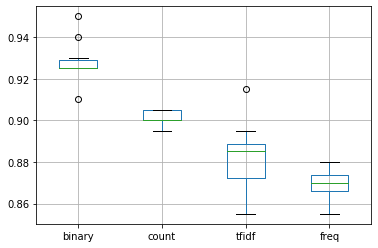

In [6]:
import string
import re
from os import listdir
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from pandas import DataFrame
from matplotlib import pyplot

#load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab, is_train):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # skip any reviews in the test set
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

# load and clean a dataset
def load_clean_dataset(vocab, is_train):
    # load documents
    neg = process_docs('txt_sentoken/neg', vocab, is_train)
    pos = process_docs('txt_sentoken/pos', vocab, is_train)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    return model

# evaluate a neural network model
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 10
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = define_model(n_words)
        # fit network
        model.fit(Xtrain, ytrain, epochs=10, verbose=0)
        # evaluate
        _, acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(acc)
        print('%d accuracy: %s' % ((i+1), acc))
    return scores

# prepare bag of words encoding of docs
def prepare_data(train_docs, test_docs, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train_docs)
    # encode training data set
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode)
    # encode training data set
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode)
    return Xtrain, Xtest

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab, True)
test_docs, ytest = load_clean_dataset(vocab, False)
# run experiment
modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
    # prepare data for mode
    Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
    # evaluate model on data for mode
    results[mode] = evaluate_mode(Xtrain, np.array(ytrain), Xtest, np.array(ytest))
# summarize results
print(results.describe())
# plot results
results.boxplot()
pyplot.show()

In [7]:
import string
import re
from os import listdir
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(directory, vocab):
    lines = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # create the full path of the file to open
        path = directory + '/' + filename
        # load and clean the doc
        line = doc_to_line(path, vocab)
        # add to list
        lines.append(line)
    return lines

# load and clean a dataset
def load_clean_dataset(vocab):
    # load documents
    neg = process_docs('txt_sentoken/neg', vocab)
    pos = process_docs('txt_sentoken/pos', vocab)
    docs = neg + pos
    # prepare labels
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

# classify a review as negative or positive
def predict_sentiment(review, vocab, tokenizer, model):
    # clean
    tokens = clean_doc(review)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    # convert to line
    line = ' '.join(tokens)
    # encode
    encoded = tokenizer.texts_to_matrix([line], mode='binary')
    # predict sentiment
    yhat = model.predict(encoded, verbose=0)
    # retrieve predicted percentage and label
    percent_pos = yhat[0,0]
    if round(percent_pos) == 0:
        return (1-percent_pos), 'NEGATIVE'
    return percent_pos, 'POSITIVE'

# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = set(vocab.split())
# load all reviews
train_docs, ytrain = load_clean_dataset(vocab)
test_docs, ytest = load_clean_dataset(vocab)
# create the tokenizer
tokenizer = create_tokenizer(train_docs)
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='binary')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='binary')
# define network
n_words = Xtrain.shape[1]
model = define_model(n_words)
# fit network
model.fit(Xtrain, np.array(ytrain), epochs=10, verbose=2)

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_162 (Dense)            (None, 50)                1288450   
_________________________________________________________________
dense_163 (Dense)            (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Epoch 1/10
63/63 - 1s - loss: 0.4427 - accuracy: 0.8120
Epoch 2/10
63/63 - 1s - loss: 0.0501 - accuracy: 0.9935
Epoch 3/10
63/63 - 1s - loss: 0.0133 - accuracy: 1.0000
Epoch 4/10
63/63 - 1s - loss: 0.0062 - accuracy: 1.0000
Epoch 5/10
63/63 - 1s - loss: 0.0031 - accuracy: 1.0000
Epoch 6/10
63/63 - 1s - loss: 0.0017 - accuracy: 1.0000
Epoch 7/10
63/63 - 1s - loss: 0.0010 - accuracy: 1.0000
Epoch 8/10
63/63 - 1s - los

In [8]:
# test positive text
text = 'Best movie ever! It was great.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))
# test negative text
text = 'This is a bad movie.'
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model)
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [Best movie ever! It was great.]
Sentiment: POSITIVE (54.522%)
Review: [This is a bad movie.]
Sentiment: NEGATIVE (65.000%)
